In [9]:
#
#
# Import Libraries
#
#

# General 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.utils import resample

# Bayes

from sklearn.naive_bayes import MultinomialNB


# Decision Tree

import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight


# BERT-specific
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import re

# RNN-specific
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

In [10]:
# 
#
# Classification Reports List
#
#

reports = []

In [11]:
#
#
# Load Dataset
#
#

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [12]:
#
#
# Decision Tree
#
#

In [13]:
#
# Data Pre-processing
#

# Function to clean text data
def clean_text(text):
    """
    Cleans text by removing URLs, mentions, hashtags, special characters, and extra spaces.
    """
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#', '', text)       # Remove hashtags
    text = re.sub(r'\W', ' ', text)     # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Preprocessing function
def preprocess_data(df):
    """
    Preprocesses the data by cleaning text, filling missing values,
    and combining features into a single column.
    """
    # Fill missing values
    df['keyword'] = df['keyword'].fillna('')
    df['location'] = df['location'].fillna('')
    df['text'] = df['text'].fillna('')

    # Clean the text
    df['text'] = df['text'].apply(clean_text)

    # Combine text, keyword, and location into a single feature
    df['combined'] = df['text'] + ' ' + (df['keyword'] * 3) + ' ' + df['location']
    return df

# Preprocess the train and test datasets
train_data_DT = preprocess_data(train_data)
test_data_DT = preprocess_data(test_data)


In [14]:
#
# Data Splitting
#

# Splitting features and target
X = train_data_DT['combined']
y = train_data_DT['target']

# Stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
#
# Build and Train Model
#

# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Define pipeline with Decision Tree
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(random_state=42, class_weight=class_weight_dict))
])

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_pipeline = grid_search.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [16]:
#
# Evaluate
#

# Evaluate on validation set
y_val_pred = best_pipeline.predict(X_val)
# print(f'Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}')
# print("\nClassification Report on Validation Data:\n")
# print(classification_report(y_val, y_val_pred))

# Gather classification report
DT_report = classification_report(y_val, y_val_pred, output_dict=True)
reports.append({
    'model': 'Decision Tree',
    'classification_report': DT_report,
    'accuracy': DT_report['accuracy'],
    'f1_score_0': DT_report['0']['f1-score'],
    'f1_score_1': DT_report['1']['f1-score']
})

# Make predictions on the test set
test_predictions = best_pipeline.predict(test_data_DT['combined'])

# Create submission file
submission_df = pd.DataFrame({'id': test_data_DT['id'], 'target': test_predictions})
submission_df.to_csv('submission_DT.csv', index=False)

In [9]:
#
#
# Naive Bayes
#
#

In [10]:
#
# Data Pre-processing
#

# Drop unnecessary columns and handle missing values
train_data_NB = train_data.drop(['id', 'keyword', 'location'], axis=1)
train_data_NB['text'] = train_data_NB['text'].fillna('')

# Resample data to handle class imbalance
positive_samples = train_data_NB[train_data_NB['target'] == 1]
negative_samples = train_data_NB[train_data_NB['target'] == 0]

negative_samples_downsampled = resample(
    negative_samples,
    replace=False,
    n_samples=len(positive_samples),
    random_state=42
)

balanced_data = pd.concat([positive_samples, negative_samples_downsampled])
balanced_data = balanced_data.sample(frac=1, random_state=42)  # Shuffle data

# Split data into features (X) and target (y)
X = balanced_data['text']
y = balanced_data['target']

# Initialize lemmatizer and stopword set
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert text to lowercase and split into words
    words = text.lower().split()
    # Remove stopwords and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply the preprocessing function to the entire dataset
X = X.apply(preprocess_text)


In [11]:
#
# Data Splitting
#

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
#
# Tokenize and pad sequences
#

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=100, padding='post', truncating='post')


In [13]:
#
# Build and Train Model
#

# Get class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Define TF-IDF Vectorizer and Naive Bayes pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])

# Fit the pipeline
nb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [14]:
#
# Evaluate
#

# Validate the model
nb_preds = nb_pipeline.predict(X_val)
# print(classification_report(y_val, nb_preds))

nb_report = classification_report(y_val, nb_preds, output_dict=True)  # Replace `nb_preds` with Naive Bayes predictions
reports.append({
    'model': 'Naive Bayes',
    'classification_report': nb_report,
    'accuracy': nb_report['accuracy'],
    'f1_score_0': nb_report['0']['f1-score'],
    'f1_score_1': nb_report['1']['f1-score']
})

# Create test data copy
test_data_NB = test_data

# Load the test data
test_data_NB['text'] = test_data_NB['text'].fillna('')

# Predict with Naive Bayes
test_preds_nb = nb_pipeline.predict(test_data_NB['text'])

outputNB = pd.DataFrame({
    'id': test_data_NB['id'],
    'target': test_preds_nb 
})

outputNB.to_csv('submission_NB.csv', index=False)


In [15]:
#
#
# RNN with LSTM
#
#

In [30]:
#
# Data Pre-processing
#

# Drop unnecessary columns and handle missing values
train_data_RNN = train_data.drop(['id', 'keyword', 'location'], axis=1)
train_data_RNN['text'] = train_data_RNN['text'].fillna('<missing>')  # Use placeholder for missing text

# Shuffle the data
train_data_RNN = train_data_RNN.sample(frac=1, random_state=42)  # Shuffle data

# Separate features (X) and target (y)
X = train_data_RNN['text']
y = train_data_RNN['target']

# Define a preprocessing function to clean text
def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()  # Keeping spaces between words
    return text

# Apply the preprocessing function to the entire dataset
X = X.apply(preprocess_text)


In [31]:
#
# Data Splitting
#

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
#
# Tokenize and pad sequences
#

# Tokenizer initialization and fitting
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Tokenize and pad sequences for training and validation sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=100, padding='post', truncating='post')


In [33]:
#
# Build and Train Model
#

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Ensure y_train and y_val are NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Build the RNN model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.3, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Bidirectional(LSTM(64, recurrent_dropout=0.3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

# Save the model
model.save('optimized_rnn_model.h5')


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.5528 - loss: 2.7420 - val_accuracy: 0.5614 - val_loss: 0.7121
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.5916 - loss: 0.6667 - val_accuracy: 0.7492 - val_loss: 0.5208
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.8008 - loss: 0.4824 - val_accuracy: 0.7748 - val_loss: 0.5162
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.8577 - loss: 0.3837 - val_accuracy: 0.7945 - val_loss: 0.4699
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.8764 - loss: 0.3527 - val_accuracy: 0.8050 - val_loss: 0.4766
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8968 - loss: 0.3051 - val_accuracy: 0.7814 - val_loss: 0.5116
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.9000 - loss: 0.2885 - val_accuracy: 0.7938 - val_loss: 0.5238
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.9057 - loss: 0

In [34]:
#
# Evaluate
#

# Evaluate the model on validation data
rnn_val_preds = (model.predict(X_val_pad) > 0.5).astype(int)
# print(classification_report(y_val, rnn_val_preds))

RNN_report = classification_report(y_val, rnn_val_preds, output_dict=True) 
reports.append({
    'model': 'RNN with LSTM',
    'classification_report': RNN_report,
    'accuracy': RNN_report['accuracy'],
    'f1_score_0': RNN_report['0']['f1-score'],
    'f1_score_1': RNN_report['1']['f1-score']
})

# Copy of test data
test_data_RNN = test_data

# Preprocess, tokenize, and pad the test data
test_data_RNN['text'] = test_data_RNN['text'].fillna('<missing>')
test_data_RNN['text'] = test_data_RNN['text'].apply(preprocess_text)

test_seq = tokenizer.texts_to_sequences(test_data['text'])
test_pad = pad_sequences(test_seq, maxlen=100, padding='post')

# Predict on test data
test_preds = (model.predict(test_pad) > 0.5).astype(int)

# Save predictions to a CSV
output = pd.DataFrame({
    'id': test_data_RNN['id'],
    'target': test_preds.flatten()
})
output.to_csv('submission_RNN_LSTM.csv', index=False)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


In [21]:
#
#
# BERT
#
#

In [22]:
#
# Data Pre-processing
#

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Text Cleaning Function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip().lower()  # Convert to lowercase

train_data_BERT = train_data
test_data_BERT = test_data

# Apply text cleaning
train_data_BERT['text'] = train_data_BERT['text'].apply(clean_text)
test_data_BERT['text'] = test_data_BERT['text'].apply(clean_text)

# Define a custom Dataset class for handling the data
class DisasterDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['text']
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        if not self.is_test:
            label = torch.tensor(row['target'], dtype=torch.long)
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': label
            }
        else:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'id': row['id']
            }


In [23]:
#
# Data Splitting
#

# Prepare training and validation sets
train_data_BERT, val_data = train_test_split(train_data_BERT, test_size=0.1, random_state=42)

# Tokenizer and Dataset creation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

train_dataset = DisasterDataset(train_data_BERT, tokenizer, max_len)
val_dataset = DisasterDataset(val_data, tokenizer, max_len)
test_dataset = DisasterDataset(test_data_BERT, tokenizer, max_len, is_test=True)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [24]:
#
# Build and Train Model
#

# Load the pretrained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

# Define optimizer, scheduler, and GradScaler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 3
)
scaler = torch.cuda.amp.GradScaler()

# Early Stopping Variables
best_val_acc = 0
patience = 2
counter = 0

# Training and Validation Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_loader)}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    bert_report = classification_report(val_labels, val_preds, output_dict=True)  # Replace `val_preds` and `val_labels` with BERT outputs
    reports.append({
    'model': 'BERT',
    'classification_report': bert_report,
    'accuracy': bert_report['accuracy'],
    'f1_score_0': bert_report['0']['f1-score'],
    'f1_score_1': bert_report['1']['f1-score']
    })

    acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {acc}")
    print(classification_report(val_labels, val_preds))

    # Early Stopping Logic
    if acc > best_val_acc:
        best_val_acc = acc
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save the best model
        print(f"Model saved with accuracy: {best_val_acc}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\Ethan\AppData\Local\Temp\ipykernel_30028\3112692320.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Py

Epoch 1, Training Loss: 0.44939020586944683


Validation Epoch 1: 100%|██████████| 48/48 [02:07<00:00,  2.66s/it]


Validation Accuracy: 0.8464566929133859
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       426
           1       0.89      0.75      0.81       336

    accuracy                           0.85       762
   macro avg       0.85      0.84      0.84       762
weighted avg       0.85      0.85      0.84       762

Model saved with accuracy: 0.8464566929133859


Training Epoch 2:   0%|          | 0/429 [00:00<?, ?it/s]C:\Users\Ethan\AppData\Local\Temp\ipykernel_30028\3112692320.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training Epoch 2: 100%|██████████| 429/429 [1:04:40<00:00,  9.04s/it]


Epoch 2, Training Loss: 0.3314590414330398


Validation Epoch 2: 100%|██████████| 48/48 [02:14<00:00,  2.81s/it]


Validation Accuracy: 0.8372703412073491
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       426
           1       0.86      0.76      0.80       336

    accuracy                           0.84       762
   macro avg       0.84      0.83      0.83       762
weighted avg       0.84      0.84      0.84       762



Training Epoch 3:   0%|          | 0/429 [00:00<?, ?it/s]C:\Users\Ethan\AppData\Local\Temp\ipykernel_30028\3112692320.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training Epoch 3: 100%|██████████| 429/429 [1:05:06<00:00,  9.11s/it]


Epoch 3, Training Loss: 0.2484663848598034


Validation Epoch 3: 100%|██████████| 48/48 [02:09<00:00,  2.69s/it]

Validation Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       426
           1       0.82      0.79      0.81       336

    accuracy                           0.83       762
   macro avg       0.83      0.83      0.83       762
weighted avg       0.83      0.83      0.83       762

Early stopping triggered


In [25]:
#
# Evaluate
#

# Load the best model for testing
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Prediction on Test Data
predictions = []
ids = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting Test Data"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        ids.extend(batch['id'].numpy())



# Create submission file
submission = pd.DataFrame({'id': ids, 'target': predictions})
submission.to_csv('submission_BERT.csv', index=False)
print("Submission file created!")


C:\Users\Ethan\AppData\Local\Temp\ipykernel_30028\553807850.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
Predicting

Submission file created!


In [ ]:
#
#
# Overall Evaluation
#
#



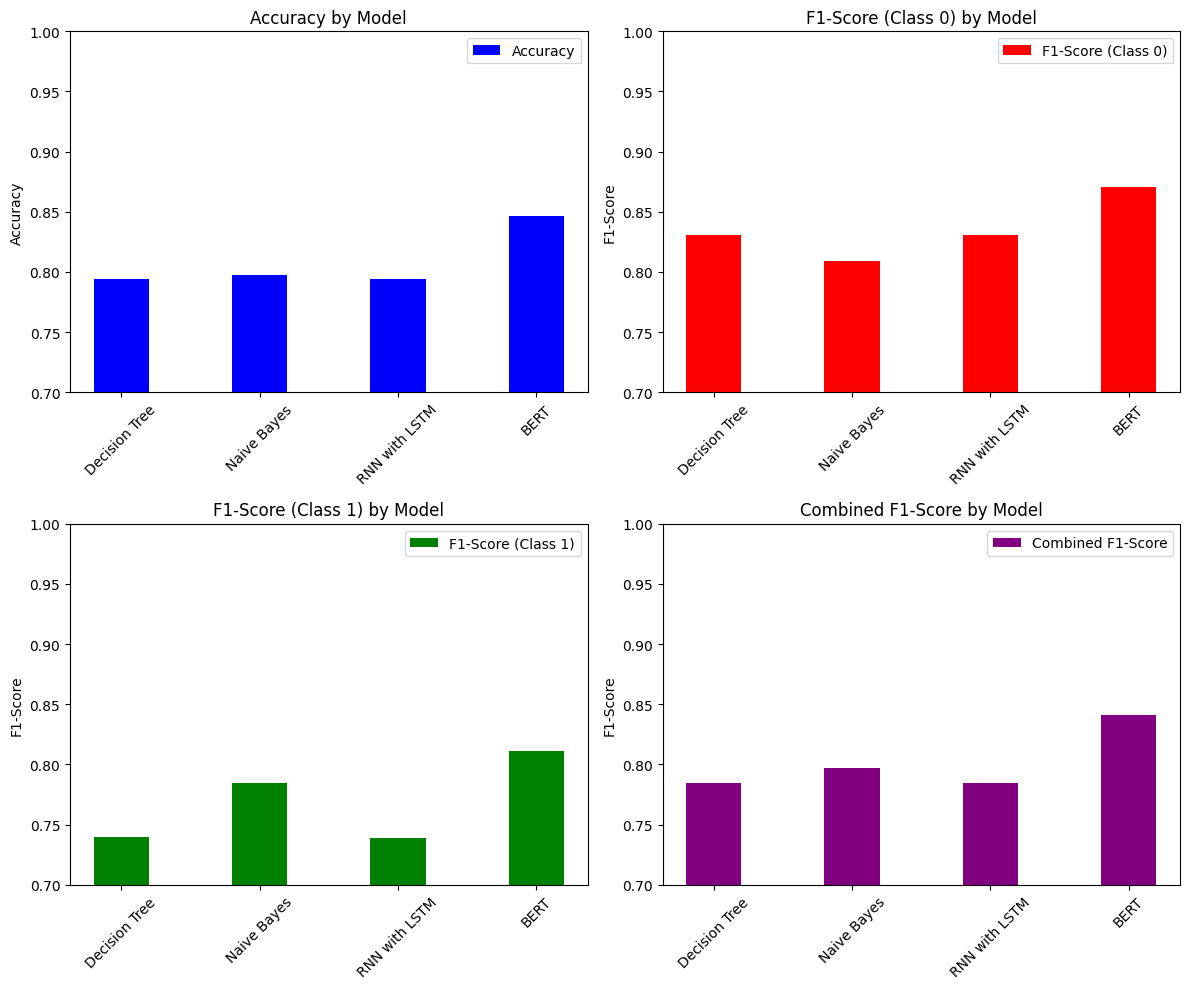

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Removing the object with model 'Random Forest'
reports = [report for report in reports if report['model'] != 'Random Forest']

# Find all BERT models in the reports list
bert_reports = [report for report in reports if report['model'] == 'BERT']

# Find the BERT report with the highest accuracy
if bert_reports:  # Ensure there are BERT models in the list
    best_bert_report = max(bert_reports, key=lambda r: r['accuracy'])

    # Remove all BERT models from the original reports list
    reports = [report for report in reports if report['model'] != 'BERT']

    # Add the best BERT report back to the list
    reports.append(best_bert_report)



# Extract data from reports
models = [report['model'] for report in reports]
accuracies = [report['accuracy'] for report in reports]
f1_scores_0 = [report['f1_score_0'] for report in reports]
f1_scores_1 = [report['f1_score_1'] for report in reports]
combined_f1_scores = [(report['f1_score_0'] + report['f1_score_1']) / 2 for report in reports]

# Set bar width and positions
bar_width = 0.4
x = np.arange(len(models))

# Create subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy plot
axs[0, 0].bar(x, accuracies, color='b', width=bar_width, label='Accuracy')
axs[0, 0].set_title('Accuracy by Model')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(models, rotation=45)
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_ylim(0.7, 1.0)  # Adjust y-axis limits
axs[0, 0].legend()

# F1-Score (Class 0) plot
axs[0, 1].bar(x, f1_scores_0, color='r', width=bar_width, label='F1-Score (Class 0)')
axs[0, 1].set_title('F1-Score (Class 0) by Model')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(models, rotation=45)
axs[0, 1].set_ylabel('F1-Score')
axs[0, 1].set_ylim(0.7, 1.0)  # Adjust y-axis limits
axs[0, 1].legend()

# F1-Score (Class 1) plot
axs[1, 0].bar(x, f1_scores_1, color='g', width=bar_width, label='F1-Score (Class 1)')
axs[1, 0].set_title('F1-Score (Class 1) by Model')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(models, rotation=45)
axs[1, 0].set_ylabel('F1-Score')
axs[1, 0].set_ylim(0.7, 1.0)  # Adjust y-axis limits
axs[1, 0].legend()

# Combined F1-Score plot
axs[1, 1].bar(x, combined_f1_scores, color='purple', width=bar_width, label='Combined F1-Score')
axs[1, 1].set_title('Combined F1-Score by Model')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(models, rotation=45)
axs[1, 1].set_ylabel('F1-Score')
axs[1, 1].set_ylim(0.7, 1.0)  # Adjust y-axis limits
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()
